# Imports

In [ ]:
#Colab run
#!git clone  https://github.com/avivabou/pal.git
#%cd pal/projects/cot/notebooks
#!ls

In [2]:
import sys, os
sys.path.append(os.path.abspath("/content/pal/src"))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import trange
from copy import deepcopy

In [3]:
# === Constants for tokenization / masking ===
# We reserve 0 for PAD everywhere.
PAD = 0

P = 11
DIGIT_OFFSET = 1  # digits -> 1..P
EOI = P + 1       # End-of-Iteration token id
VOCAB_SIZE = EOI + 1  # tokens: 0..EOI

print(f"PAD={PAD}, P={P}, EOI={EOI}, VOCAB_SIZE={VOCAB_SIZE}")

PAD=0, P=11, EOI=12, VOCAB_SIZE=13


# Hyper-params

In [4]:
epochs = 1000
batch_size = 256
min_len = 8
max_len = 10
total_runs = 10

config = TransformerConfig(
    vocab_size=VOCAB_SIZE,
    emb_dim=128,
    n_head=1,
    seq_len=32,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)



# Data

In [5]:
class PolyDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16, p=11):
        self.p = p
        self.samples = []
        for _ in range(N):
            x = torch.randint(0, p, (random.randint(2, seq_len),))
            y = (x[0] * x[1] + 1) % p
            target = torch.full((x.size(0),), p, dtype=torch.long)  # label marker
            target[-1] = y
            self.samples.append((x, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [6]:
class PolyCOTDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16, p=P, func=None, min_len=min_len):
        self.p = p
        self.func = (lambda x, y: (x * y + 1)) if func is None else func
        self.samples = []

        for _ in range(N):
            L = np.random.randint(min_len, seq_len + 1)
            x_raw = torch.randint(0, p, (L,))
            x_tok = x_raw + DIGIT_OFFSET

            states = torch.empty(L, dtype=torch.long)
            states[0] = (int(x_raw[0]) % p)
            for t in range(1, L):
                prev = int(states[t-1])
                curx = int(x_raw[t])
                states[t] = int(self.func(prev, curx)) % p

            s_tok = states + DIGIT_OFFSET

            inp = torch.cat([x_tok, torch.tensor([EOI])])
            inp_full = torch.cat([inp, s_tok[:-1]]) if L > 1 else inp

            tgt_full = torch.cat([torch.full((len(x_tok)+1,), PAD), s_tok])

            self.samples.append((inp_full, tgt_full))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [7]:
class ParityDataset(torch.utils.data.Dataset):
    def __init__(self, N=16384, seq_len=16):
        self.samples = []
        for _ in range(N):
            length = np.random.randint(2, seq_len + 1)
            bits = torch.randint(0, 2, (length,), dtype=torch.long)
            x_tok = bits + 1
            parity = torch.cumsum(bits, dim=0) % 2
            y_tok = parity + 1
            inp = torch.cat([x_tok, torch.tensor([EOI], dtype=torch.long)])
            inp_full = torch.cat([inp, y_tok[:-1]]) if length > 1 else inp
            tgt_full = torch.cat([torch.full((len(x_tok)+1,), PAD, dtype=torch.long), y_tok])
            self.samples.append((inp_full, tgt_full))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)



In [8]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=PAD)
    ys = pad_sequence(ys, batch_first=True, padding_value=PAD)

    # Trim to per-batch max non-PAD length so inputs contain no pads
    true_lengths = (xs != PAD).sum(dim=1)
    Lmax = int(true_lengths.max().item())
    xs = xs[:, :Lmax]
    ys = ys[:, :Lmax]

    return xs, ys


# Model Object

In [9]:
class Trainer:
    all_accuracies = []

    def __init__(self, config, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config = config
        self.model = Transformer(config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        self.criterion = nn.CrossEntropyLoss(ignore_index=PAD)
        self.batch_size = batch_size
        self.task_counter = {}
        self.accuracies = []
        self.static_index = len(Trainer.all_accuracies)
        self.dataset = None
        Trainer.all_accuracies.append([])
        self.all_accuracies_flat = []

    def reset_optimizer(self, lr=3e-4):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, task='polynomial', epochs=10):
        while len(Trainer.all_accuracies) <= self.static_index:
          Trainer.all_accuracies.append([])
        if task == 'polynomial':
            # dataset = PolyDataset()
            dataset = PolyCOTDataset()
            self.dataset = dataset
        elif task == 'parity':
            dataset = ParityDataset()
            self.dataset = dataset
        else:
            raise ValueError("Unknown task")

        count = self.task_counter.get(task, 0) + 1
        self.task_counter[task] = count
        task_name = f"{task} {count}"

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        accs = []

        pbar = trange(epochs)
        for epoch in pbar:
            self.model.train()
            total_loss = 0
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.criterion(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()


            acc = self.evaluate(loader, verbose=False)
            accs.append(acc)
            avg_loss = total_loss / len(loader)
            pbar.set_description(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Acc: {acc:.2%}")

        self.accuracies.append({
            "name": task_name,
            "accs": accs
        })

        self.all_accuracies_flat = [a for entry in self.accuracies for a in entry["accs"]]
        Trainer.all_accuracies[self.static_index] = self.all_accuracies_flat

    def evaluate(self, loader, verbose=True):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)
                keep = (y != PAD)
                correct += ((preds == y) & keep).sum().item()
                total   += keep.sum().item()
        acc = correct / total
        if verbose:
            print(f"Accuracy: {acc:.2%}")
        return acc

    def plot_accuracy(self, save_path):
        if not self.accuracies:
            print("No runs to plot.")
            return

        start_x = 0
        for entry in self.accuracies:
            name = entry["name"]
            accs = entry["accs"]
            x = list(range(start_x, start_x + len(accs)))
            plt.plot(x, accs, label=name)
            start_x += len(accs)

        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.savefig(save_path, dpi=200)
        plt.show()


    def plot_attentions_heatmap(self, save_path):
          # self.model.load_state_dict(deepcopy(self.model.state_dict()))
          self.model.eval()
          seq = self.dataset[-4000][0].unsqueeze(0).to(self.device)

          with torch.no_grad():
              logits, attentions = self.model(seq, verbose=True)

          attn0 = attentions[0, 0, 0].cpu()
          attn1 = attentions[1, 0, 0].cpu()

          fig, axes = plt.subplots(1, 2, figsize=(10, 5))
          im0 = axes[0].imshow(attn0, aspect='auto', origin='lower')
          im1 = axes[1].imshow(attn1, aspect='auto', origin='lower')
          axes[0].imshow(attn0)
          axes[1].imshow(attn1 > 0.5)

          axes[0].set_title("First attention map")
          axes[1].set_title("Second attention map")
          axes[0].set_xlabel("Key tokens")
          axes[1].set_xlabel("Key tokens")
          axes[0].set_ylabel("Query token")
          axes[0].set_yticks([])
          axes[1].yaxis.tick_right()

          fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
          fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

          # mark the EOI column
          eoi_pos = (seq[0] == EOI).nonzero(as_tuple=True)[0]
          if len(eoi_pos) > 0:
              eoi_pos = int(eoi_pos[0].item())
              for ax in axes:
                  ax.axvline(eoi_pos, color='white', linestyle='--', linewidth=1)

          plt.savefig(save_path,  bbox_inches="tight")
          plt.show()
          plt.close(fig)


    def fork(self):
        new_trainer = Trainer(self.config, batch_size=self.batch_size)
        new_trainer.model.load_state_dict(deepcopy(self.model.state_dict()))
        new_trainer.optimizer.load_state_dict(deepcopy(self.optimizer.state_dict()))
        new_trainer.criterion = deepcopy(self.criterion)
        new_trainer.task_counter = deepcopy(self.task_counter)
        new_trainer.accuracies = deepcopy(self.accuracies)

        while len(Trainer.all_accuracies) <= new_trainer.static_index:
            Trainer.all_accuracies.append([])

        Trainer.all_accuracies[new_trainer.static_index] = deepcopy(
            Trainer.all_accuracies[self.static_index]
        )

        return new_trainer

    @staticmethod
    def summarize_runs(save_path):
        # Filter out any empty lists
        valid_runs = [a for a in Trainer.all_accuracies if a]

        if not valid_runs:
            print("No valid runs to summarize.")
            return

        max_len = max(len(a) for a in valid_runs)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in valid_runs]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.savefig(save_path, dpi=200)
        plt.show()

# Train

In [10]:
# --- Replication default: 2-layers ---
trainer = Trainer(config)
trainer.train(task='polynomial', epochs=200)

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:41<00:00,  1.71s/it]


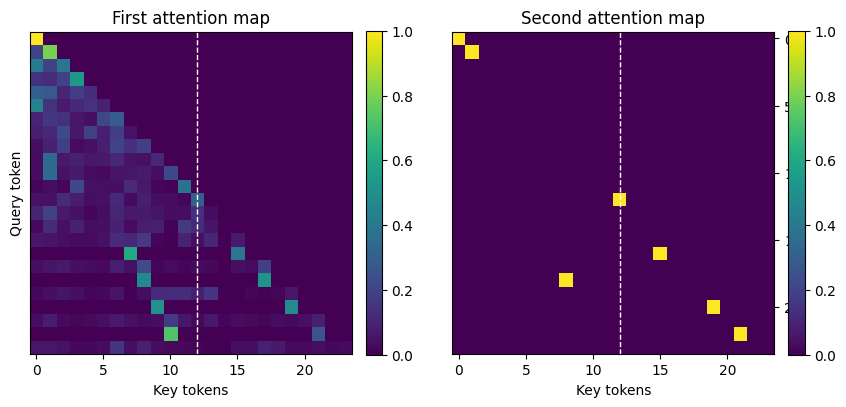

In [11]:
trainer.plot_attentions_heatmap('/content/outputs/attn_poly_2layers.png')

In [12]:
trainer.reset_optimizer()
trainer.train(task='parity', epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-100162170.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


# Evaluation

In [13]:
parity_loader = DataLoader(ParityDataset(N=16384), batch_size=256, collate_fn=collate_fn)
trainer.dataset = parity_loader.dataset
trainer.evaluate(parity_loader)

/tmp/ipython-input-100162170.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


Accuracy: 100.00%


1.0

# Visualize

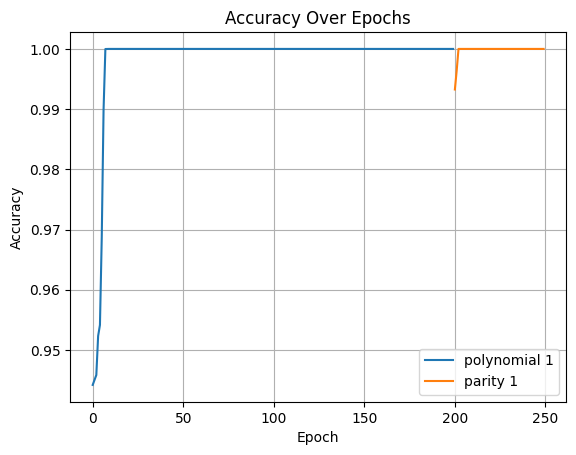

In [14]:
trainer.plot_accuracy(save_path='/content/outputs/accuracy_2layes.png')

/tmp/ipython-input-100162170.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


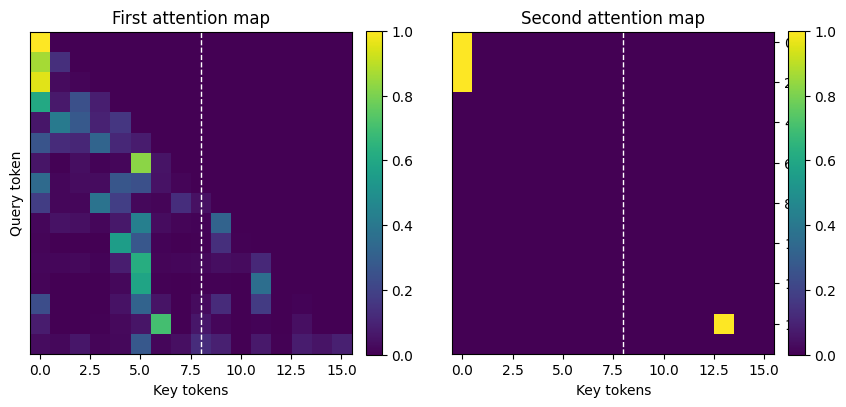

In [15]:
trainer.plot_attentions_heatmap(save_path='/content/outputs/attentions_parity_2layes.png')

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [08:39<00:00,  2.60s/it]


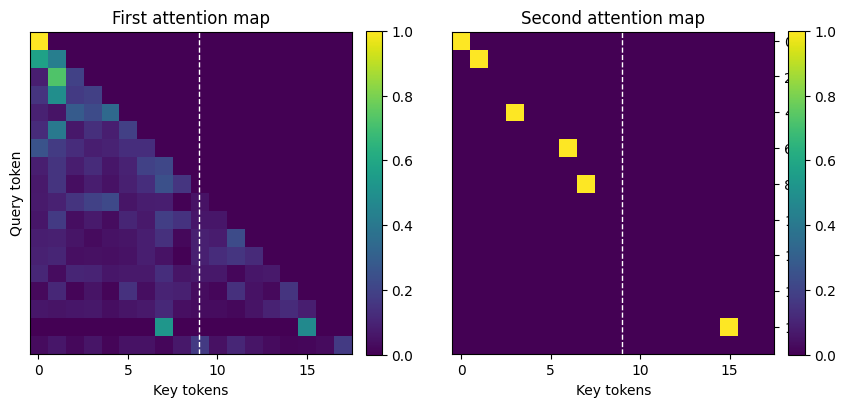

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-100162170.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [02:33<00:00,  3.08s/it]


Accuracy: 100.00%


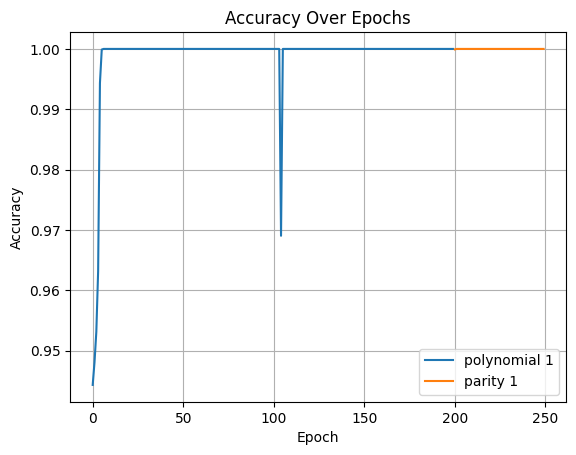

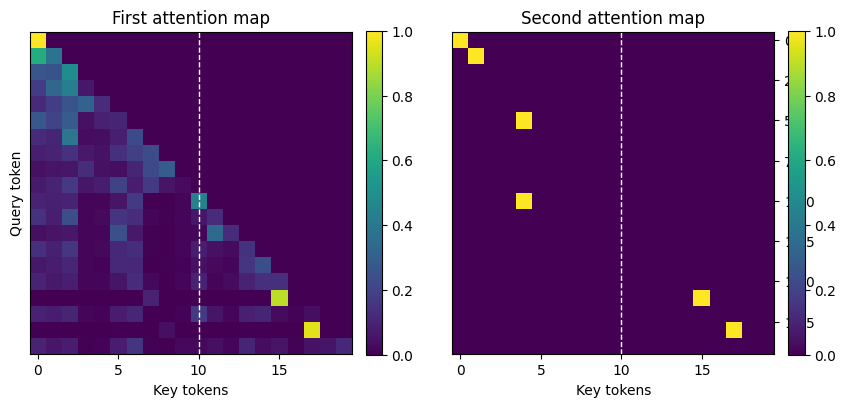

In [16]:
# --- Depth Study: 4-layers ---
# Train with 4 trnsformer layers
config.n_layer = 4
trainer = Trainer(config)
trainer.train(task='polynomial', epochs=200)
# heatmap for poly with 4 layers
trainer.plot_attentions_heatmap('/content/outputs/attn_poly_4layers.png')
# Perity with 4 layer
trainer.reset_optimizer()
trainer.train(task='parity', epochs=50)
parity_loader = DataLoader(ParityDataset(N=16384), batch_size=256, collate_fn=collate_fn)
trainer.dataset = parity_loader.dataset
trainer.evaluate(parity_loader)
#acc & attention
trainer.plot_accuracy(save_path='/content/outputs/accuracy_4layes.png')
trainer.plot_attentions_heatmap(save_path='/content/outputs/attentions_parity_4layes.png')


Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:32<00:00,  3.46s/it]


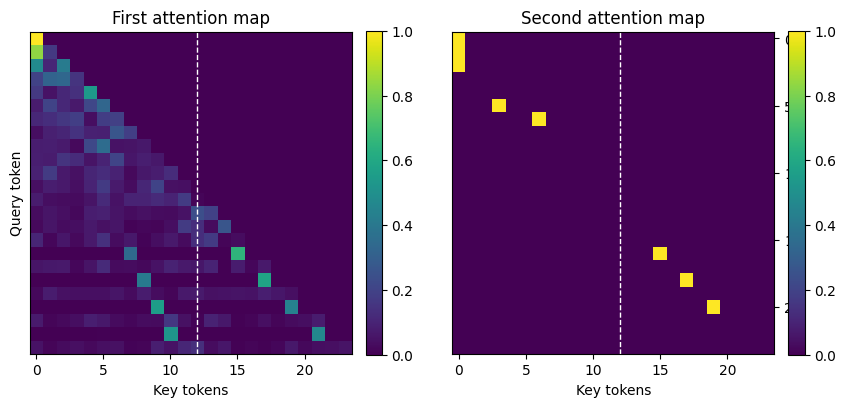

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-100162170.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [03:18<00:00,  3.98s/it]


Accuracy: 100.00%


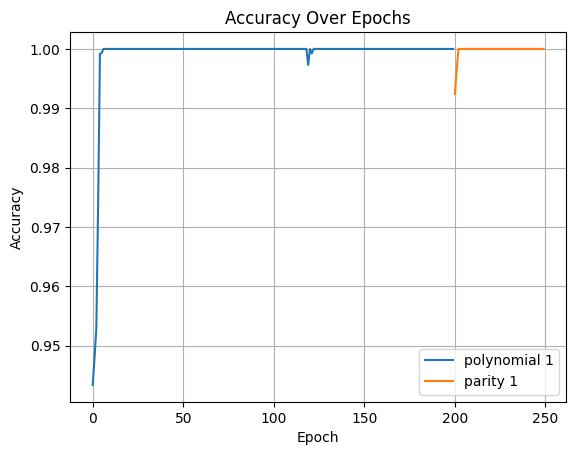

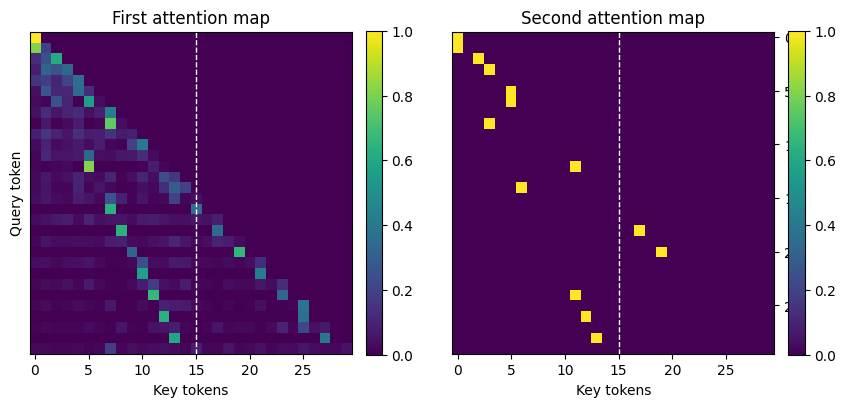

In [17]:
# --- Depth Study: 6-layers ---
config.n_layer = 6
trainer = Trainer(config)
trainer.train(task='polynomial', epochs=200)
# heatmap for poly with 6 layers
trainer.plot_attentions_heatmap('/content/outputs/attn_poly_6layers.png')
# Perity with 6 layer
trainer.reset_optimizer()
trainer.train(task='parity', epochs=50)
parity_loader = DataLoader(ParityDataset(N=16384), batch_size=256, collate_fn=collate_fn)
trainer.dataset = parity_loader.dataset
trainer.evaluate(parity_loader)
#acc & attention
trainer.plot_accuracy(save_path='/content/outputs/accuracy_6layes.png')
trainer.plot_attentions_heatmap(save_path='/content/outputs/attentions_parity_6layes.png')

# Multi-runs

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:55<00:00,  1.78s/it]
  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-100162170.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:55<00:00,  1.78s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:54<00:00,  1.77s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [05:55<00:00,  1.78s/it]
Epoch 49 | Loss: 0.0000 

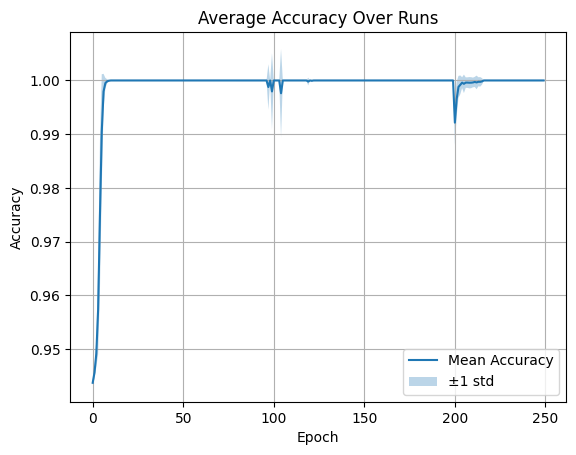

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [08:45<00:00,  2.63s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [08:46<00:00,  2.63s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [08:46<00:00,  2.63s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]
Epoch 199 | Loss: 0.1267 | Acc: 100.00%: 100%|██████████| 200/200 [08:45<00:00,  2.63s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [08:45<00:00,  2.63s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [08:46<00:00,  2.63s/it]
Epoch 49 | Los

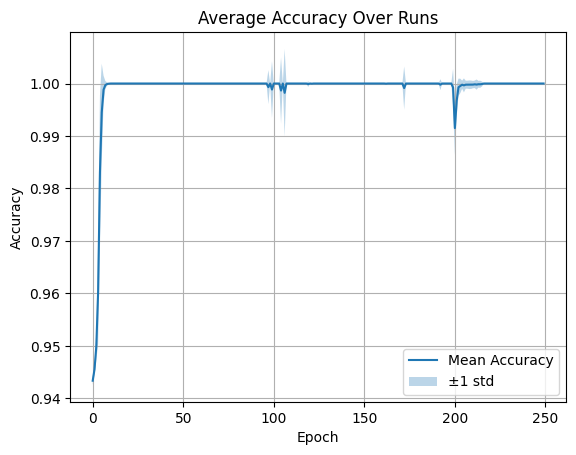

Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:35<00:00,  3.48s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [03:17<00:00,  3.95s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:34<00:00,  3.47s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [03:17<00:00,  3.96s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:36<00:00,  3.48s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [03:17<00:00,  3.95s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:35<00:00,  3.48s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [03:18<00:00,  3.97s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:35<00:00,  3.48s/it]
Epoch 49 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 50/50 [03:18<00:00,  3.97s/it]
Epoch 199 | Loss: 0.0000 | Acc: 100.00%: 100%|██████████| 200/200 [11:35<00:00,  3.48s/it]
Epoch 49 | Los

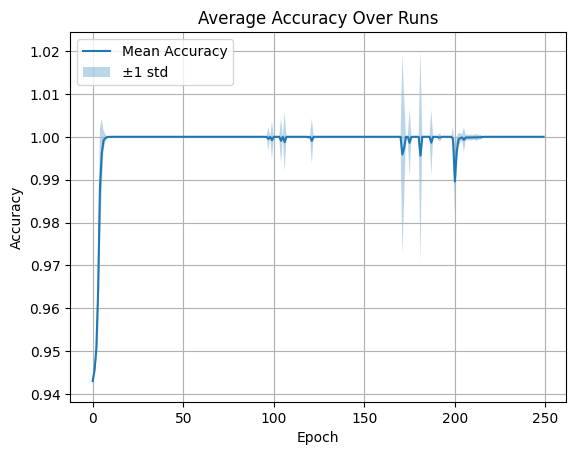

In [18]:
transformer_layer = [2,4,6]
for ly in transformer_layer:
    config.n_layer = ly
    for _ in range(total_runs):
        trainer = Trainer(config)
        trainer.train(task='polynomial', epochs=200)
        trainer.reset_optimizer()
        trainer.train(task='parity', epochs=50)

    # After several trainers
    Trainer.summarize_runs(save_path=f'/content/outputs/multi_run_{ly}layers.png')
